# World Health Organization Mental Health Resources Study

Dr. Pablo Salcado &
Dr. Kelly Epley

This notebook documents the code we used to conduct our analysis of the WHO suicide data and data on global mental health resources by country and suicide rates (ages 15-29) per 100,000 population in those countries in 2016.

Additional code can by found in the .py files in the repository. 

In this study, we treat lower suicide rates as a proxy for the effectiveness of available mental health resources. We want to emphasize that it is an imperfect proxy, but one that is easily quantifiable and representative of clear failures of intervention. See the accompanying readme for a detailed explanation of our rationale for the study and our background research.

## Packages used in our analysis

In [4]:
import pandas as pd
import numpy as np
import sqlite3
from statistics import mean, stdev
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bootstrap_and_compare_function import*

## The database

In [5]:
conn=sqlite3.connect("/Users/flatironschool/Desktop/who_suicide.db")
c=conn.cursor()


### Table Schema

| suicide_rate | 
|------|
|   Country
    Year
    15-29 years 
    35-50 years | 
    
| human_resources | 
|------|
|   Country
    Year
    Psychologists working in mental health sector (per 100 000 population)
    Nurses working in mental health sector (per 100 000 population)
    Social workers working in mental health sector (per 100 000 population)
    Psychiatrists working in mental health sector (per 100 000 population) | 
    
| facilities | 
|------|
|   Country
    Year
    Mental hospitals (per 100 000 population)
    Mental health units in general hospitals (per 100 000 population)
    Mental health outpatient facilities (per 100 000 population)
    Mental health day treatment facilities (per 100 000 population)
    Community residential facilities (per 100 000 population |

## Preparing the data

In [6]:
# Calculating the mean values of the columns in the human_resources table so we can fill in nulls

df_with_nulls = pd.read_sql_query("""SELECT
                          Country,
                          CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) AS Psychologists,
                          CAST([Nurses working in mental health sector (per 100 000 population)] AS float) AS Nurses,
                          CAST([Social workers working in mental health sector (per 100 000 population)] AS float) AS Social_Workers,
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float) AS Psychiatrists,
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources;""", con=conn)

# Creating DataFrames with populations of interest

df_suicide_rate_btsx_above = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel >= 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Both sexes";""", con=conn)

df_suicide_rate_btsx_below = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel < 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Both sexes";""", con=conn)

df_suicide_rate_male_above = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel >= 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Male";""", con=conn)

df_suicide_rate_male_below = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel < 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Male";""", con=conn)

df_suicide_rate_female_above = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel >= 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Female";""", con=conn)

df_suicide_rate_female_below = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel < 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Female";""", con=conn)


# Does availability of mental health providers improve mental health outcomes?

* ### Alternative Hypothesis 1:

There is a difference in suicide rates for countries below and above the mean threshold of mental health providers per 100,000 people ages 15-29.

* ### Null Hypothesis: 

There is no difference.

Note: mental health providers include psychiatrists, psychologists, dedicated mental health nurses, social workers.

As you can see from the image below, distributions of suicides in countries with above average vs. below average number of providers are not normal distributions. Also, our "above average" group is small.

Hence, we decided to bootstrap samples and create a sampling distribution to compare the populations.



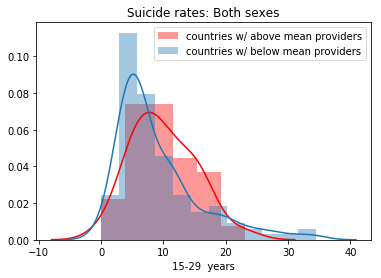

In [14]:
sns.distplot(df_suicide_rate_btsx_above["15-29  years"], color='red', label="countries w/ above mean providers")
sns.distplot(df_suicide_rate_btsx_below["15-29  years"], label="countries w/ below mean providers")
plt.title("Suicide rates: Both sexes")
plt.legend()
plt.savefig("raw_dist_btsx")

* ### T TEST for two independent samples

We generated 1000 samples of 500 with replacement from the original samples. The results of the T test were significant, but the effect size is small. Note that, somewhat surprisingly, countries with more mental health resources have more reported suicides for ages 15-29. See the readme for discussion.

With p=0.0, we can reject the Null Hypothesis. These populations are different.


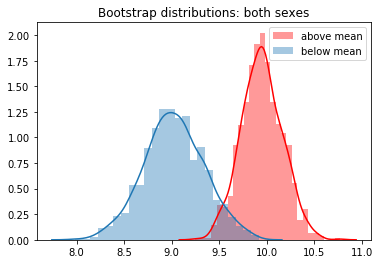

In [15]:
samp1=df_suicide_rate_btsx_above["15-29  years"]
samp2=df_suicide_rate_btsx_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)

plt.title("Bootstrap distributions: both sexes")
plt.savefig("bootstrap_dist_btsx")

In [16]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: 0.15328557489069433


# Do we get different results when we look at the outcomes for males only? 

* ### Alternative Hypothesis 2:

There is a difference in suicide rates for males in countries below and above the mean threshold of mental health providers per 100,000 for people ages 15-29.

* ### Null Hypothesis: 

There is no difference.

Here is a plot of the original sample distributions. We again bootstrapped sample and plotted the sampling distributions by the same procedure as before. 


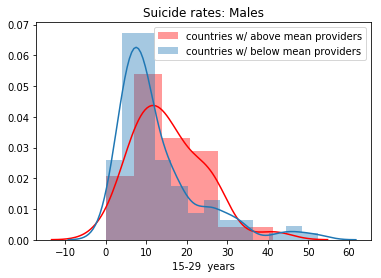

In [26]:
sns.distplot(df_suicide_rate_male_above["15-29  years"], color='red', label="countries w/ above mean providers")
sns.distplot(df_suicide_rate_male_below["15-29  years"], label="countries w/ below mean providers")
plt.title("Suicide rates: Males")
plt.legend()
plt.savefig("raw_dist_males")

### T TEST: 2 independent samples

Similar to our previous results, we found that countries with more mental health resources also had more suicides reported, though the effect size is small.



With p=0.0, we can reject the Null Hypothesis. These populations are different.


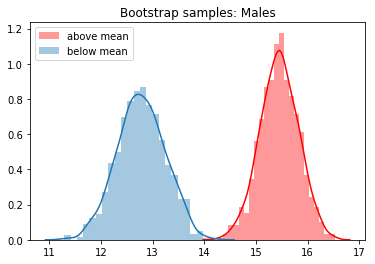

In [29]:
samp1=df_suicide_rate_male_above["15-29  years"]
samp2=df_suicide_rate_male_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)
plt.title("Bootstrap samples: Males")
plt.legend()
plt.savefig("bootstrap_dist_males")

In [30]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: 0.28373686568030676


# Females only?

* ### Alternative Hypothesis 3:

There is a difference in suicide rates for females in countries below and above the mean threshold of mental health professionals per 100,000 for people ages 15-29.

* ### Null Hypothesis: 

There is no difference.

Here are the raw distributions prior to our bootstrapping procedure.

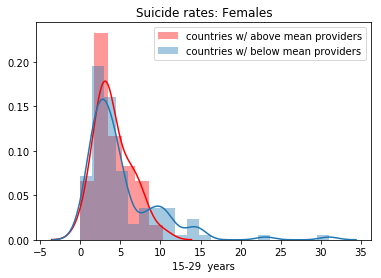

In [24]:
sns.distplot(df_suicide_rate_female_above["15-29  years"], color='red', label="countries w/ above mean providers")
sns.distplot(df_suicide_rate_female_below["15-29  years"], label="countries w/ below mean providers")
plt.title("Suicide rates: Females")
plt.legend()
plt.savefig("raw_dist_females")


### T TEST: 2 independent samples

This time the above mean population has lower suicide rates than the below mean population though the effect size is small.

With p=0.0, we can reject the Null Hypothesis. These populations are different.


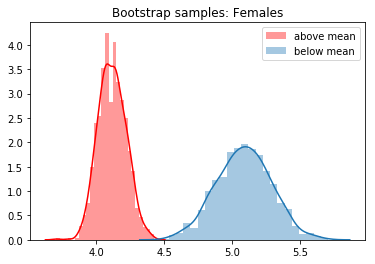

In [25]:
samp1=df_suicide_rate_female_above["15-29  years"]
samp2=df_suicide_rate_female_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)
plt.title("Bootstrap samples: Females")
plt.legend()
plt.savefig("bootstrap_dist_females")

In [13]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: -0.26564335647727033


# ANOVA?

In [49]:
# getting the quantiles of total_mh_personnel so we can break the populations up into groups

df = pd.read_sql_query("""SELECT
                          Country,
                          CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) AS Psychologists,
                          CAST([Nurses working in mental health sector (per 100 000 population)] AS float) AS Nurses,
                          CAST([Social workers working in mental health sector (per 100 000 population)] AS float) AS Social_Workers,
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float) AS Psychiatrists,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources ;""", con=conn)


In [50]:
df.describe()

,Psychologists,Nurses,Social_Workers,Psychiatrists,total_mh_personnel
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,9.704578,12.663916,3.364045,4.868208,30.600747
std,29.045814,24.874641,16.266182,8.041757,55.832789
min,0.000000,0.000000,0.000000,0.000000,0.035000
25%,0.013000,0.219500,0.000000,0.130000,1.565750
50%,0.560000,2.593500,0.068000,1.239000,8.025500
75%,3.060250,10.563000,0.643000,5.934250,27.670750
max,222.572000,150.251000,145.400000,48.040000,277.478000


In [58]:
# making a dataframe with a resources_quantile column

df = pd.read_sql_query("""SELECT Country, [15-29  years] as suicide_rate_per_100_000,
                            CASE 
                              WHEN total_mh_personnel <= 1.57
                                  THEN 0
                              WHEN (total_mh_personnel > 1.57) AND (total_mh_personnel <= 8.03)
                                  THEN 1
                              WHEN (total_mh_personnel > 8.03) AND (total_mh_personnel <= 27.67)
                                  THEN 2
                              ELSE 3
                            END AS resources_quantile
                          FROM (SELECT Country,
                               CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) AS Psychologists,
                               CAST([Nurses working in mental health sector (per 100 000 population)] AS float) AS Nurses,
                               CAST([Social workers working in mental health sector (per 100 000 population)] AS float) AS Social_Workers,
                               CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float) AS Psychiatrists,
                               COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                               COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                               COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                               COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                               CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                               + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                               + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                               + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                               FROM human_resources) 
                            LEFT JOIN suicide_rate
                            USING(Country)
                            WHERE Sex = "Both sexes";""", con=conn)

                          

In [59]:
# df = df.drop([0,1,2,4,9], axis=0)
# df.head(10)

0    39
3    37
2    37
1    36
Name: resources_quantile, dtype: int64

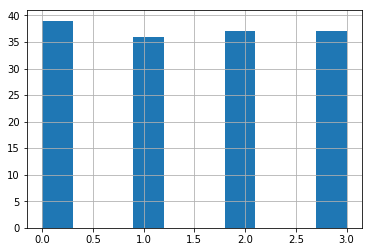

In [60]:
df.resources_quantile.hist()
df.resources_quantile.value_counts()

In [61]:
# making a df with yes/no for stand alone mental health law

gov = pd.read_csv("/Users/flatironschool/Desktop/Kelly/mental_health_governance.csv")
gov = gov[['Country', 'Stand-alone law for mental health']]
gov.set_index('Country', inplace=True)
df.set_index('Country', inplace=True)

In [62]:
df = df.merge(gov, on='Country')

In [46]:
df['Stand-alone law for mental health'].where(df['Stand-alone law for mental health']!='Yes', 1, inplace=True)
df['Stand-alone law for mental health'].where(df['Stand-alone law for mental health']!='No', 0, inplace=True)

In [63]:
df.head()

,suicide_rate_per_100_000,resources_quantile,Stand-alone law for mental health
Country,,,
Afghanistan,8.4,0,Yes
Afghanistan,8.4,0,Yes
Albania,6.9,2,Yes
Albania,6.9,2,Yes
Angola,5.8,0,No


In [23]:

S = 'suicide_rate_per_100_000'
F1 = 'resources_quantile'
F2 = 'Stand-alone law for mental health'
data = df

formula = 'S ~ C(F1)'

sm.tools.tools.add_constant(data)
lm = ols(formula, data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


PatsyError: Number of rows mismatch between data argument and S (277 versus 1)
    S ~ C(F1)
    ^